In [103]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from layers import FreeSpacePropagation
import time
import pandas as pd
import cv2
from cxlayers import AngularSpectrum, ImageResizing, ImageToElectricField, ImageBinarization, CxMO, CxD2NNFaradayRotation, CxD2NNIntensity, D2NNMNISTDetector, Polarizer, GGG, Softmax


plt.rcParams["font.size"]=18

In [104]:
class Polarizer(tf.keras.layers.Layer):
    def __init__(self, output_dim, phi=0.0, trainable=False):
        super(Polarizer, self).__init__()
        self.output_dim = output_dim
        self.phi = tf.Variable(phi, name="phi", trainable=trainable)
        self.trainable = trainable

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "phi":  self.phi.numpy(),
            "trainable": self.trainable
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def call(self, x):
        rcp_x = tf.keras.layers.Lambda(lambda x:x[:,0,0,:,:])(x)
        rcp_y = tf.keras.layers.Lambda(lambda x:x[:,0,1,:,:])(x)
        lcp_x = tf.keras.layers.Lambda(lambda x:x[:,1,0,:,:])(x)
        lcp_y = tf.keras.layers.Lambda(lambda x:x[:,1,1,:,:])(x)

        p00 = tf.complex(tf.cos(self.phi)**2.0, 0.0)
        p01 = tf.complex(tf.sin(-2.0 * self.phi) / 2.0, 0.0)
        p10 = p01
        p11 = tf.complex(tf.sin(self.phi)**2.0, 0.0)

        rcp_x_pol = p00 * rcp_x + p01 * rcp_y
        rcp_y_pol = p10 * rcp_x + p11 * rcp_y

        lcp_x_pol = p00 * lcp_x + p01 * lcp_y
        lcp_y_pol = p10 * lcp_x + p11 * lcp_y

        rcp = tf.stack([rcp_x_pol, rcp_y_pol], axis=1)
        lcp = tf.stack([lcp_x_pol, lcp_y_pol], axis=1)

        rl = tf.stack([rcp, lcp], axis=1)

        return rl

In [105]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [106]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

In [122]:
shape = (100, 100)
inputs = tf.keras.layers.Input((28, 28))
x = ImageResizing(shape)(inputs)
x = ImageBinarization(0.5, 0.0, 1.0)(x)
x = ImageToElectricField(shape)(x)
x = CxMO(shape)(x)
x = Polarizer(shape, phi=np.pi/6)(x)
x = CxD2NNIntensity(shape)(x)

model = tf.keras.Model(inputs, x)
model.summary()
# model.save("test")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_4 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 image_binarization_4 (Image  (None, 100, 100)         0         
 Binarization)                                                   
                                                                 
 image_to_electric_field_4 (  (None, 2, 2, 100, 100)   0         
 ImageToElectricField)                                           
                                                                 
 cx_mo_4 (CxMO)              (None, 2, 2, 100, 100)    10001     
                                                           

In [4]:
ones = np.ones((10, 28, 28))
pred = model.predict(ones)

2022-04-10 21:12:20.456086: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 21:12:20.506170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57.29577268289315


2022-04-14 13:05:55.574440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


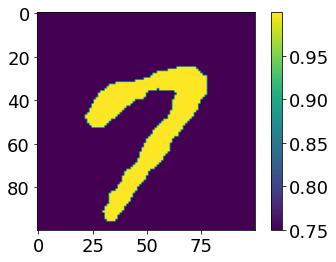

In [123]:
weights = model.layers[4].get_weights()
phase = np.loadtxt("data/phase/100px/train_7.csv") *np.pi/6
tx = np.linspace(-np.pi, np.pi, 100)
ty = np.linspace(-np.pi, np.pi, 100)
XX, YY = np.meshgrid(tx, ty)
W = np.sqrt(XX**2 + YY**2)
weights[0] = phase
model.layers[4].set_weights(weights)
image = np.ones((2, 28, 28))
pred = model.predict(image)
plt.imshow(pred[0,:,:])
plt.colorbar()
print(np.max(pred) * 180/np.pi)

In [59]:
model.layers[4].get_weights()

[]

2022-04-08 17:01:07.165986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


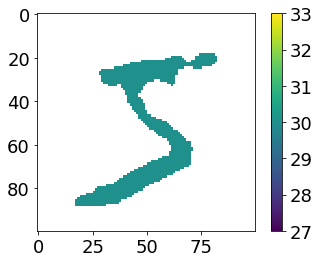

In [11]:
pred = model.predict(x_train[0:10,:,:])
plt.imshow(pred[0,:,:] * 180/np.pi)
plt.colorbar()

In [44]:
class MOD2NN(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 複数モデルを入れ子にすることもOK
        self.model = self.create_model()
        # トラッカーを用意する（訓練、テスト共通で良い）
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.loss_tracker = tf.keras.metrics.SparseCategoricalCrossentropy()
        self.accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        self.accuracy_tracker = tf.keras.metrics.SparseCategoricalAccuracy()

    def create_model(self):
        shape = (40, 40)
        inputs = tf.keras.layers.Input((28, 28))
        x = ImageResizing(shape)(inputs)
        x = ImageBinarization(0.5, 0, 1)(x)
        x = ImageToElectricField(shape)(x)
        x = CxMO(shape)(x)
        x = AngularSpectrum(shape, 531e-9, 0.5e-3, d=2.0e-6,n=1.0, method='expand')(x)
        x = CxD2NNIntensity(shape)(x)
        x = D2NNMNISTDetector(10)(x)
        return tf.keras.models.Model(inputs, x)

    # なくてもエラーは出ないが、訓練・テスト間、エポックの切り替わりで
    # トラッカーがリセットされないため、必ずmetricsのプロパティをオーバーライドすること
    # self.reset_metrics()はこのプロパティを参照している
    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy]

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            pred = self.model(x)
            loss_value = self.loss_object(y, pred)
            accuracy_value = self.accuracy(y, pred)
        # 全体（self）に対する偏微分か、特定モデル（self.model）に対する微分かは場合により変わる
        # このケースではどちらでも同じだが、GANでは使い分ける必要がある
        grads = tape.gradient(loss_value, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # エポックの切り替わりのトラッカーのリセットは、self.reset_metrics()で自動的に行われる
        self.loss_tracker.update_state(y, pred)
        self.accuracy_tracker.update_state(y, pred)

        return {
            "loss": self.loss_tracker.result(),
            "accuracy": self.accuracy_tracker.result()
        }

    def test_step(self, data):
        x, y = data

        pred = self.model(x)
        loss = self.loss_object(y, pred)

        # 訓練・テストの切り替わりのトラッカーのリセットは、self.reset_metrics()で自動的に行われる
        self.loss_tracker.update_state(loss)
        return {
            "loss": self.loss_tracker.result()
        }

In [45]:
model =MOD2NN()
model.compile(optimizer=tf.keras.optimizers.Adam())
model.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10


2022-04-03 20:58:45.307114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 32/938 [>.............................] - ETA: 7:53 - loss: 2.4210 - accuracy: 0.1094

KeyboardInterrupt: 

In [42]:
x = tf.complex(2.0, 3.0)

with tf.GradientTape() as t:
  t.watch(x)
  z = tf.multiply(3.0, x)

# 元の入力テンソル x に対する z の微分
dz_dx = t.gradient(z, x)
dz_dx

<tf.Tensor: shape=(), dtype=complex64, numpy=(3+0j)>

(0.0, 1.0)

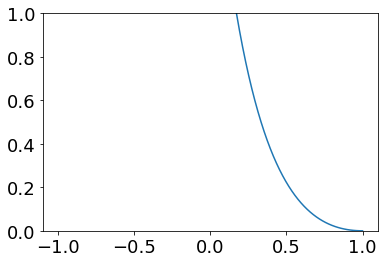

In [47]:
eta = np.linspace(-0.99999, 0.99999, 100)
Er = 1.0
I = 2 * Er * (1-eta)**2 / (eta+1)**2
plt.plot(eta, I)
plt.ylim(0, 1)

In [134]:
def calc_argument(cmpx):
        real = tf.math.real(cmpx)
        imag = tf.math.imag(cmpx)

        arg = tf.where(tf.not_equal(imag, 0.0), 2.0*tf.atan((tf.sqrt(real**2 + imag**2)-real)/imag), 0.0)
        arg = tf.where((real > 0.0) & (tf.equal(imag, 0.0)), 0.0, arg)
        arg = tf.where((real < 0.0) & tf.equal(imag, 0.0), np.pi, arg)
        arg = tf.where(tf.equal(real, 0.0) & tf.equal(imag, 0.0), 0.0, arg)

        return arg

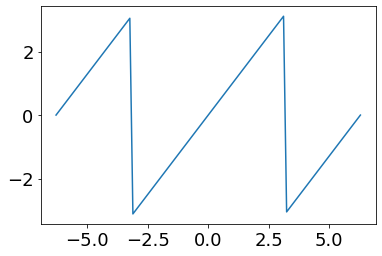

In [135]:
x = np.linspace(-2*np.pi, 2*np.pi, 100)
phi = np.exp(1.0j * x)
y = calc_argument(phi)
plt.plot(x, y)

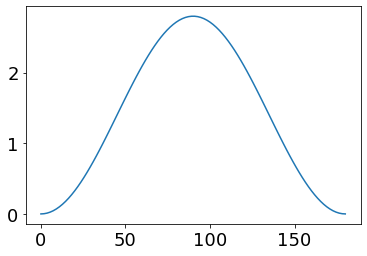

In [102]:
def pol_mat(phi):
    return np.array([[np.cos(phi)**2, np.sin(phi) * np.cos(phi)], [ np.sin(phi) * np.cos(phi), np.sin(phi)**2]])

phi = np.linspace(0, np.pi, 100)
rcp_phase = np.exp(1.0j * phi)
lcp_phase = np.exp(1.0j * -phi)
rcp_hat = np.array([[1.], [1.0j]])
lcp_hat = np.array([[1.], [-1.0j]])
rcp = rcp_hat * rcp_phase
lcp = lcp_hat * lcp_phase
tot = rcp + lcp

pm1 = pol_mat(-np.pi/2)
pm2 = pol_mat(-np.pi/3)

out = []

for i in range(100):
    out.append(pm2 @ pm1 @ tot[:, i])

out = np.array(out)
I = np.abs(out[:, 0])**2 + np.abs(out[:, 1])**2
plt.plot(phi*180/np.pi, I)